# Sources:
- https://keras.io/applications/#inceptionv3
- https://www.tensorflow.org/hub/tutorials/image_retraining
- https://www.kaggle.com/learn/deep-learning
- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://towardsdatascience.com/deep-learning-with-tensorflow-part-2-image-classification-58fcdffa7b84
- https://medium.com/google-developer-experts/building-robust-production-ready-deep-learning-vision-models-in-minutes-acd716f6450a
- https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks

- https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb
- https://github.com/FlorianWoelki/pneumonia_detection/blob/master/pneumonia_detection.ipynb
- https://github.com/Dexter1618/MMWML/blob/master/Week04/Pneumonia_Detection_Transfer_Learning.ipynb


# Concepts:
 - Transfer learning: Modern image recognition models have millions of parameters.Training them from scratch requires a lot of labeled training data and a lot of computing power (hundreds of GPU-hours or more). Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.
 - ImageDataGenerator().flow_from_directory(directory): Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.
 - Relu : Following each convolution operation, the CNN applies a Rectified Linear Unit (ReLU) transformation to the convolved feature, in order to introduce nonlinearity into the model. The ReLU function, , returns x for all values of x > 0, and returns 0 for all values of x ≤ 0.

In [1]:
# Download dataset
# Load files
# Use ImageNet into InceptionV3 model
# Transfer learning into new model oriented for xray pneumonia prediction.
# Train only the part of the new model
# Make Measurements

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_image_data_config(kind, path):
    
    assert kind in ('train', 'test', 'valid'), f'unknown kind: {kind}'

    image_data_gen_config = {
        'rescale': 1./255.,
        'width_shift_range':0.1,
        'height_shift_range':0.1,
        'shear_range':0.2,
        'zoom_range':0.2,
        'horizontal_flip':True,
    }

    flow_from_dir_config = {
        'target_size': (150, 150),
        'batch_size': 32,
        'class_mode': 'categorical',
        'color_mode': 'rgb',
        'shuffle': True,
        'seed': None,
        'interpolation': 'nearest',
    }

    if kind == 'train':
        return image_data_gen_config, flow_from_dir_config

    # test, valid
    img_tp = image_data_gen_config.copy()
    wanted = ('rescale', )
    image_data_gen_config = dict((k,v) for k,v in img_tp.items() if k in wanted)

    #if kind == 'valid':
    #    flow_from_dir_config['batch_size'] = 1
    
    flow_from_dir_config['shuffle'] = False
    return image_data_gen_config, flow_from_dir_config


class XRayData:
    
    @property
    def train_generator(self):
        return self._get_or_set('train_generator')
    
    @property
    def test_generator(self):
        return self._get_or_set('test_generator')
    
    @property
    def valid_generator(self):
        return self._get_or_set('valid_generator')

    @property
    def train_class_weights(self):
        return self._get_or_set('train_class_weights')
    
    def _set_train_generator(self, path='./data/input/train'):
        config1, config2 = get_image_data_config('train', path)
        tp = ImageDataGenerator(**config1)
        self._train_generator = tp.flow_from_directory(path, **config2)
    
    def _set_test_generator(self, path='./data/input/test'):
        config1, config2 = get_image_data_config('train', path)
        tp = ImageDataGenerator(**config1)
        self._test_generator = tp.flow_from_directory(path, **config2)
        
    def _set_valid_generator(self, path='./data/input/val'):
        config1, config2 = get_image_data_config('valid', path)
        tp = ImageDataGenerator(**config1)
        self._valid_generator = tp.flow_from_directory(path, **config2)
    
    def _set_train_class_weights(self):
        from sklearn.utils.class_weight import compute_class_weight
        from numpy import unique
        y = self.train_generator.classes
        labels = unique(y)
        self._train_class_weights = compute_class_weight("balanced", labels, y)
    
    def _get_or_set(self, attr):
        attr = f'_{attr}'
        if not hasattr(self, attr):
            getattr(self, f'_set{attr}')()
        return getattr(self, attr)
    

xraydata = XRayData()
xraydata.train_generator
xraydata.test_generator
xraydata.valid_generator
xraydata.train_class_weights

C:\Users\Admin\Anaconda3\envs\PythonCPU\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


array([1.9448173 , 0.67303226])

In [3]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
clear_session()
base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
base_model.trainable = False    # Transfer learning is here (not retrained model)

# extra part: specific to pneumonia xray training.
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax')) # 2 : num of classes

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics = ["accuracy"])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_94 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 23,907,106
Trainable params: 2,102,274
Non-trainable params: 21,804,832
__________________________________________________

In [5]:
from datetime import datetime
start = datetime.now()
print("STARTED at :", start)
history = model.fit_generator(xraydata.train_generator, 
                                steps_per_epoch = len(xraydata.train_generator),
                                epochs = 20,
                                verbose = 1,
                                workers = 20,
                                validation_data = xraydata.valid_generator, 
                                validation_steps = len(xraydata.valid_generator),
                                class_weight = xraydata.train_class_weights)

STARTED at : 2019-09-28 20:08:05.386273
Epoch 1/20
163/163 [==============================] - 118s 721ms/step - loss: 0.4331 - acc: 0.8204 - val_loss: 0.6507 - val_acc: 0.7500
Epoch 2/20
163/163 [==============================] - 114s 700ms/step - loss: 0.3054 - acc: 0.8785 - val_loss: 1.5542 - val_acc: 0.5625
Epoch 3/20
163/163 [==============================] - 114s 701ms/step - loss: 0.2622 - acc: 0.8957 - val_loss: 1.5725 - val_acc: 0.6250
Epoch 4/20
163/163 [==============================] - 115s 704ms/step - loss: 0.2549 - acc: 0.8970 - val_loss: 1.4580 - val_acc: 0.7500
Epoch 5/20
163/163 [==============================] - 115s 705ms/step - loss: 0.2492 - acc: 0.8992 - val_loss: 1.3946 - val_acc: 0.6250
Epoch 6/20
163/163 [==============================] - 113s 696ms/step - loss: 0.2489 - acc: 0.8984 - val_loss: 1.0097 - val_acc: 0.6875
Epoch 7/20
163/163 [==============================] - 111s 684ms/step - loss: 0.2348 - acc: 0.9097 - val_loss: 1.8697 - val_acc: 0.6875
Epoch 8/

NameError: name 'now' is not defined

In [6]:
end = datetime.now()
print("ENDED at", end)
print((end-start).total_seconds() / 60.)

ENDED at 2019-09-28 20:46:38.848823
38.55770916666667


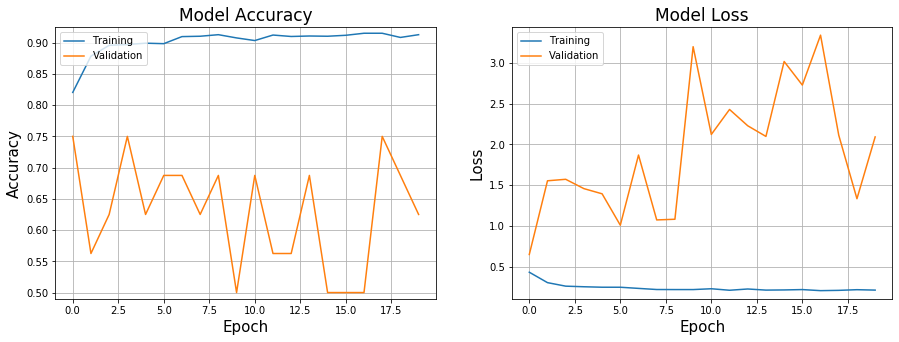

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]

plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [13]:
from sklearn.metrics import classification_report

target_names = ["normal", "pneumonia"]
for _set in (xraydata.test_generator,):
    y_pred = model.predict_generator(_set,
                                     steps = len(_set),
                                     verbose = 0)
    y_true = _set.classes
    y_pred = y_pred.argmax(axis=-1)
    print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

      normal       0.36      0.06      0.10       234
   pneumonia       0.62      0.94      0.75       390

    accuracy                           0.61       624
   macro avg       0.49      0.50      0.42       624
weighted avg       0.53      0.61      0.51       624



In [24]:
from random import randint
import cv2
label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

def display_sample(y_true, y_pred):
    test_file_names = xraydata.test_generator.filenames
    n = len(test_file_names)

    plt.rcParams["figure.figsize"] = 12, 10

    for i in range(2):
        index = randint(0, n - 1)
        file_name = "data/input/test/"+ test_file_names[index]
        image = cv2.imread(file_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        ground_truth_label = label_dict[int(y_true[index])]
        predicted_label = label_dict[int(y_pred[index])]
    
        plt.subplot(5, 1, i + 1)
        plt.axis("off")
        plt.imshow(image)
    
        title = "Ground Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
        plt.title(title)

    plt.tight_layout()
    plt.show()

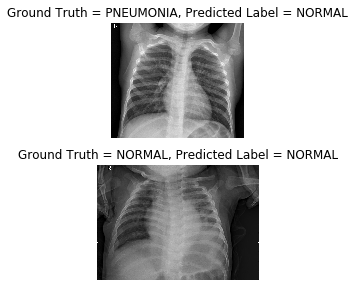

In [25]:
display_sample(y_true, y_pred)